### Imports

In [13]:
# basics
import numpy as np
import pandas as pd
import math
import json
import matplotlib.pyplot as plt

### Load data

In [2]:
# VALID DATA
valid_json = '../data/valid_QC.json'
with open(valid_json, 'r') as file:
    valid_data = json.load(file)

# INVALID DATA
invalid_json = '../data/invalid_QC.json'
with open(invalid_json, 'r') as file:
    invalid_data = json.load(file)

In [3]:
print(len(valid_data), len(invalid_data))

202 145


In [4]:
measured_df = pd.read_csv('../data/measured.csv')
measured_df = measured_df.dropna(subset=['PhotoID', 'Laser Width', 'BodyLength1'])

In [5]:
laser_width = dict(zip(measured_df['PhotoID'], measured_df['Laser Width']))
body_length = dict(zip(measured_df['PhotoID'], measured_df['BodyLength1']))
pix_laser = dict(zip(measured_df['PhotoID'], measured_df['PixLaser1']))
pix_length = dict(zip(measured_df['PhotoID'], measured_df['PixLength1']))

### Get errors and predictions for validated data

In [6]:
# iterate through each entry in json
valid_predictions = []
count = 0 # number of images that were able to generate a prediction
valid_fails =[] # store names of images where model failed

# store specific errors
errors = []
laser_errors = []
body_errors = []
for image_name, info in valid_data.items():
    # distances in pixels
    laser_points = info['laser_points']
    body_points = info['shoulder_rump']

    if laser_points and body_points:
        # calculate pixel distances
        laser_dist = round(math.dist(laser_points[0], laser_points[1]), 1) # spreadsheet rounds this value to 1
        body_dist = round(math.dist(body_points[0], body_points[1]), 1) # same here
        ratio = laser_dist / body_dist

        # lookup laser width
        photo_id = image_name.split('.')[0]
        laser_in = laser_width[photo_id]
        
        # compare results
        predicted_length = laser_in / ratio
        valid_predictions.append(predicted_length)
        true_length = body_length[photo_id]
        
        error = round(abs(predicted_length - true_length) / true_length, 3) * 100
        errors.append(error)

        # count number of predictions with less than 10% error
        if error < 10:
            count += 1

        # laser error
        true_laser = pix_laser[photo_id]
        laser_error = round(abs(laser_dist - true_laser) / true_laser, 3) * 100
        laser_errors.append(laser_error)

        # body error
        true_body = pix_length[photo_id]
        body_error = round(abs(body_dist - true_body) / true_body, 3)
        body_errors.append(body_error*100)
    else:
        valid_fails.append(image_name)

print(f"{count} / {len(valid_data) - len(valid_fails)} images with less than 10 percent error")
print(f"model was unable to generate prediction for {len(valid_fails)} images")

114 / 167 images with less than 10 percent error
model was unable to generate prediction for 35 images


### Get predictions for non-validated data

In [7]:
# iterate through each entry in json
invalid_predictions = []
invalid_fails =[] # store names of images where model failed

for image_name, info in invalid_data.items():
    # distances in pixels
    laser_points = info['laser_points']
    body_points = info['shoulder_rump']

    if laser_points and body_points:
        # calculate pixel distances
        laser_dist = round(math.dist(laser_points[0], laser_points[1]), 1) # spreadsheet rounds this value to 1
        body_dist = round(math.dist(body_points[0], body_points[1]), 1) # same here
        ratio = laser_dist / body_dist

        # lookup laser width
        if image_name.startswith("KCP"):
            laser_in = 4.45
        else:
            laser_in = 4.6
        
        # compare results
        predicted_length = laser_in / ratio
        invalid_predictions.append(predicted_length)

    else:
        invalid_fails.append(image_name)

print(f"model was unable to generate prediction for {len(invalid_fails)} images")

model was unable to generate prediction for 38 images


### Explore Results

In [10]:
data = {
    'Measurement': ['Final Error', 'Laser Error', 'Body Error'],
    'Mean': [np.mean(errors), np.mean(laser_errors), np.mean(body_errors)],
    'Median': [np.median(errors), np.median(laser_errors), np.median(body_errors)],
    'Std Dev': [np.std(errors), np.std(laser_errors), np.std(body_errors)],
    'Min': [np.min(errors), np.min(laser_errors), np.min(body_errors)],
    'Max': [np.max(errors), np.max(laser_errors), np.max(body_errors)]
}
# Create a DataFrame
results_df = pd.DataFrame(data)

In [11]:
# Print the DataFrame
print(results_df)

   Measurement       Mean  Median    Std Dev  Min    Max
0  Final Error  27.289820     5.8  64.336236  0.2  470.8
1  Laser Error  21.666467     1.0  61.328892  0.0  424.6
2   Body Error   6.129940     4.3   7.900993  0.1   67.9


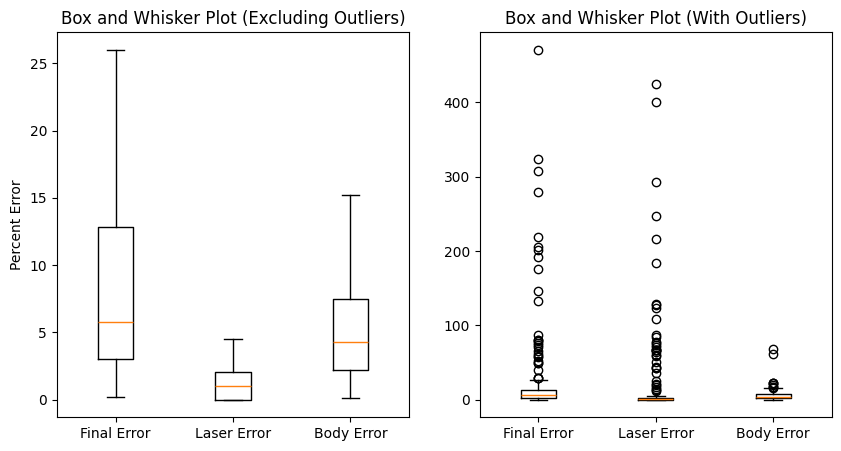

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.flatten()

data = [errors, laser_errors, body_errors]
axs[0].boxplot(data, showfliers=False)
axs[0].set_ylabel("Percent Error")
axs[0].set_xticks([1, 2, 3], ['Final Error', 'Laser Error', 'Body Error'])
axs[0].set_title('Box and Whisker Plot (Excluding Outliers)')

axs[1].boxplot(data, showfliers=True)
axs[1].set_xticks([1, 2, 3], ['Final Error', 'Laser Error', 'Body Error'])
axs[1].set_title('Box and Whisker Plot (With Outliers)')

plt.show()

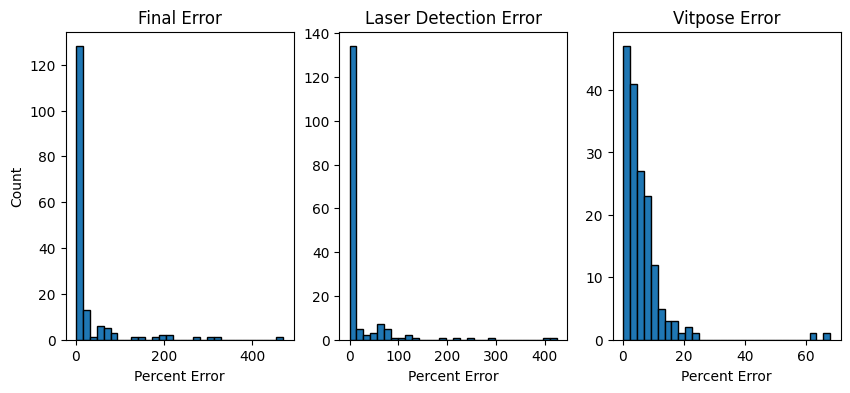

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
axs = axs.flatten()

axs[0].hist(errors, bins=30, edgecolor='black')
axs[0].set_xlabel("Percent Error")
axs[0].set_ylabel("Count")
axs[0].set_title("Final Error")

axs[1].hist(laser_errors, bins=30, edgecolor='black')
axs[1].set_xlabel("Percent Error")
axs[1].set_title("Laser Detection Error")

axs[2].hist(body_errors, bins=30, edgecolor='black')
axs[2].set_xlabel("Percent Error")
axs[2].set_title("Vitpose Error")

plt.show()

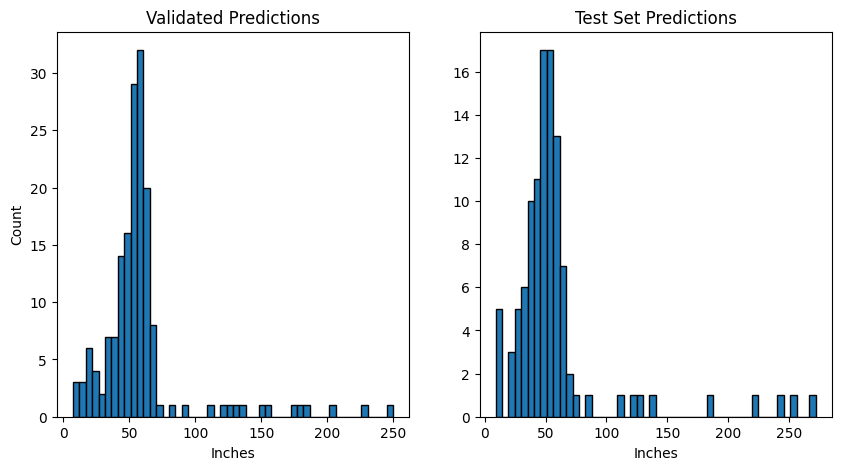

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.flatten()

axs[0].hist(valid_predictions, bins=50, edgecolor='black')
axs[0].set_xlabel("Inches")
axs[0].set_ylabel("Count")
axs[0].set_title("Validated Predictions")

axs[1].hist(invalid_predictions, bins=50, edgecolor='black')
axs[1].set_xlabel("Inches")
axs[1].set_title("Test Set Predictions")

plt.show()

In [50]:
preds = {
    'Set': ['Valid', 'Invalid'],
    'Mean': [np.mean(valid_predictions), np.mean(invalid_predictions)],
    'Median': [np.median(valid_predictions), np.median(invalid_predictions)],
    'Std Dev': [np.std(valid_predictions), np.std(invalid_predictions)],
    'Min': [np.min(valid_predictions), np.min(invalid_predictions)],
    'Max': [np.max(valid_predictions), np.max(invalid_predictions)]
}
# Create a DataFrame
predictions_df = pd.DataFrame(preds)

In [51]:
# Print the DataFrame
print(predictions_df)

       Set       Mean     Median    Std Dev       Min         Max
0    Valid  59.091866  54.361006  35.727542  7.265899  250.017188
1  Invalid  58.664250  49.927692  44.672778  8.933401  272.300318
